In [10]:
from fastai.vision.all import *
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import cv2
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
path = Path('/home/azaidi/Desktop/kaggle/seti')
Path.BASE_PATH = path
path.ls()

(#7) [Path('data'),Path('effnet.ipynb'),Path('models'),Path('initial.ipynb'),Path('seti-breakthrough-listen.zip'),Path('.ipynb_checkpoints'),Path('data_extract.ipynb')]

In [3]:
(path/'data/train').ls()

(#17) [Path('data/train/9'),Path('data/train/e'),Path('data/train/3'),Path('data/train/5'),Path('data/train/7'),Path('data/train/d'),Path('data/train/b'),Path('data/train/1'),Path('data/train/a'),Path('data/train/0')...]

In [4]:
(path/'data/train').ls()[0].ls()

(#3139) [Path('data/train/9/9f0dff2cd2b3.npy'),Path('data/train/9/91af44908241.npy'),Path('data/train/9/923ed9e2e4d8.npy'),Path('data/train/9/990f15496627.npy'),Path('data/train/9/92a91b53e5ee.npy'),Path('data/train/9/9567d242de97.npy'),Path('data/train/9/9f5cb9d7a0d6.npy'),Path('data/train/9/9aea15089923.npy'),Path('data/train/9/9deb1a9a72a5.npy'),Path('data/train/9/9e26f4ef6fc6.npy')...]

In [5]:
train_df = pd.read_csv(path/'data/train_labels.csv')
sub_df = pd.read_csv(path/'data/sample_submission.csv')

In [9]:
train_df.shape

(50165, 2)

In [6]:
train_df.head(2)

,id,target
0,00034abb3629,0
1,0004300a0b9b,0


In [7]:
sub_df.head(1)

,id,target
0,00034db451c4,0.5


In [17]:
data_path = path/'data'

In [18]:
train_df['path'] = train_df['id'].apply(lambda x: str(data_path/'train'/x[0]/x)+'.npy')

In [19]:
train_df.tail(3)

,id,target,path
50162,fffaf1658eb7,0,/home/azaidi/Desktop/kaggle/seti/data/train/f/fffaf1658eb7.npy
50163,fffb0fc8c613,0,/home/azaidi/Desktop/kaggle/seti/data/train/f/fffb0fc8c613.npy
50164,fffd1cad9995,0,/home/azaidi/Desktop/kaggle/seti/data/train/f/fffd1cad9995.npy


In [20]:
def kfold_idxs(df, n_splits):
    train_idx, val_idx = [], []
    skf = KFold(n_splits=n_splits, shuffle=True)
    for train_index, valid_index in skf.split(df.path, df.target):
        train_idx.append(train_index)
        val_idx.append(valid_index)
    return train_idx, val_idx

def get_val_idxs(df, n_splits):
    _, val_idxs = kfold_idxs(df, n_splits)
    return val_idxs

In [21]:
v_idxs = get_val_idxs(train_df, 3)
len(v_idxs)

3

In [83]:
class SETIDataset:
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = self.df.iloc[index].target
        filename = self.df.iloc[index].path
        data = np.load(filename).astype(np.float32)
        
        #this will return a 256x1638 tensor per sample
        #data = data.astype(np.float32)
        #data = np.vstack(data).transpose((1, 0))
        
        #this will get you a 512x512 tensor per sample
        data = np.vstack(data).transpose((1, 0))
        data = cv2.resize(data, dsize=(512,512))     
        
        data_tensor = torch.tensor(data).float().unsqueeze(0)

        return (data_tensor, torch.tensor(label))

In [84]:
# t_df, v_df = train_test_split(train_df, test_size=0.2)

In [85]:
v_idxs[0].shape, train_df.shape

((16722,), (50165, 3))

In [86]:
train_df.iloc[v_idxs[0]].shape, train_df.drop(v_idxs[0]).shape

((16722, 3), (33443, 3))

In [87]:
train_df.shape[0] == (train_df.iloc[v_idxs[0]].shape[0] + train_df.drop(v_idxs[0]).shape[0])

True

In [88]:
def get_dfs(df, v_idxs, fold):
    t_df = df.iloc[v_idxs[fold]].reset_index()
    v_df = df.drop(v_idxs[fold]).reset_index()
    return t_df, v_df

In [89]:
t_df, v_df = get_dfs(train_df, v_idxs, 0)
len(t_df), len(v_df)

(16722, 33443)

In [90]:
t_ds = SETIDataset(t_df)
v_ds = SETIDataset(v_df)

In [91]:
t_ds[0][0].shape

torch.Size([1, 512, 512])

In [16]:
#sample = np.load(train_df.path[0])
#sample.shape

In [17]:
#np.vstack(sample).shape, np.vstack(sample).transpose((1,0)).shape

In [111]:
bs = 64
train_dl = torch.utils.data.DataLoader(t_ds, batch_size=bs,num_workers=8)
valid_dl = torch.utils.data.DataLoader(v_ds, batch_size=bs,num_workers=8)

In [112]:
len(train_dl), len(valid_dl)

(262, 523)

In [113]:
dls = DataLoaders(train_dl, valid_dl)

In [30]:
#batch = next(iter(dls.train))

In [31]:
#batch[0].shape

In [98]:
def roc_auc(preds,targ):
    try: return roc_auc_score(targ.cpu(),preds.squeeze().cpu())
    except: return 0.5

In [99]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model.to('cuda')

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_in=3, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, n_in=n_in, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [105]:
#timm.list_models('*')

In [114]:
learn = timm_learner(dls,'seresnext26d_32x4d',pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0691830962896347)

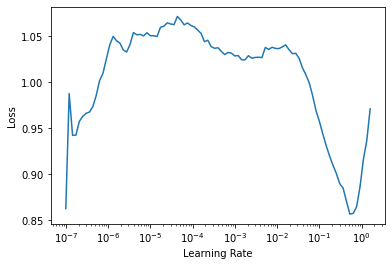

In [115]:
learn.lr_find()

In [117]:
learn.fit_one_cycle(3, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.226410,0.169337,0.906429,03:46
1,0.106181,0.079814,0.966361,03:43
2,0.064560,0.071020,0.969072,03:44


SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=7.585775847473997e-07)

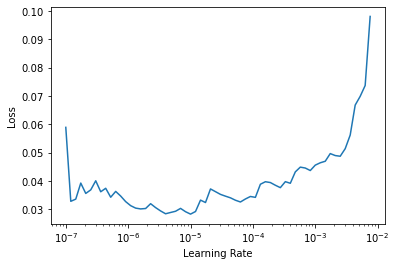

In [118]:
learn.unfreeze()
learn.lr_find()

In [119]:
learn.fit_one_cycle(3, slice(5e-6,5e-4), wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.058093,0.070829,0.968713,04:34
1,0.046456,0.071901,0.968580,04:34
2,0.040302,0.072377,0.969029,04:34


Epoch 1: reducing lr to 2.0790353431297374e-05
Epoch 2: reducing lr to 8.550049324465049e-10


In [120]:
#learn = learn.to_fp32()

In [121]:
#learn.save('testing')

In [126]:
learn = timm_learner(dls,'seresnext26d_32x4d',pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()

In [127]:
learn.fit_flat_cos(7, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.166808,0.124173,0.944433,03:44
1,0.111786,0.089493,0.963583,03:45
2,0.098001,0.078413,0.968491,03:45
3,0.097994,0.088988,0.967021,03:45
4,0.078140,0.081398,0.970165,03:45
5,0.072935,0.074972,0.974215,03:45
6,0.045463,0.073600,0.975374,03:45


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005


In [ ]:
t_df, v_df = get_dfs(train_df, v_idxs, 0)

In [ ]:
t_ds = SETIDataset(t_df)
v_ds = SETIDataset(v_df)
dls = DataLoaders(train_dl, valid_dl)
bs = 64
train_dl = torch.utils.data.DataLoader(t_ds, batch_size=bs,num_workers=8)
valid_dl = torch.utils.data.DataLoader(v_ds, batch_size=bs,num_workers=8)

In [131]:
def get_dls(fold, bs=64):
    t_df, v_df = get_dfs(train_df, v_idxs, fold)
    t_ds = SETIDataset(t_df)
    v_ds = SETIDataset(v_df)
    train_dl = torch.utils.data.DataLoader(t_ds, batch_size=bs,num_workers=8)
    valid_dl = torch.utils.data.DataLoader(v_ds, batch_size=bs,num_workers=8)
    dls = DataLoaders(train_dl, valid_dl)
    return dls

In [132]:
for x in range(len(v_idxs)):
    dls = get_dls(x)
    learn = timm_learner(dls,'seresnext26d_32x4d',pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
    learn.fit_flat_cos(7, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau()])   
    learn.save(f'seresnext_fold_{x}')

epoch,train_loss,valid_loss,roc_auc,time
0,0.165322,0.139330,0.939743,03:45
1,0.114166,0.096010,0.962221,03:45
2,0.101928,0.079002,0.963911,03:46
3,0.098987,0.085486,0.969185,03:46
4,0.077560,0.083797,0.969062,03:45
5,0.070461,0.066375,0.971860,03:46
6,0.042015,0.068205,0.973136,03:45


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005
Epoch 6: reducing lr to 1.0868623102136543e-07


epoch,train_loss,valid_loss,roc_auc,time
0,0.158392,0.102905,0.955245,03:46
1,0.112051,0.079342,0.967417,03:46
2,0.079196,0.072116,0.967733,03:46
3,0.079427,0.093850,0.960520,03:46
4,0.078082,0.075415,0.973131,03:46
5,0.069109,0.075312,0.972966,03:46
6,0.041847,0.065240,0.975000,03:46


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005
Epoch 5: reducing lr to 0.0030730086227141722


epoch,train_loss,valid_loss,roc_auc,time
0,0.174608,0.236376,0.886846,03:52
1,0.110374,0.094449,0.959018,03:46
2,0.090694,0.086349,0.958626,03:46
3,0.079763,0.087103,0.956674,03:46
4,0.077755,0.086585,0.959095,03:46
5,0.055393,nan,0.961692,03:46
6,0.031082,0.082725,0.967285,03:46


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005
Epoch 5: reducing lr to 0.0030730086227141722


SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=6.309573450380412e-07)

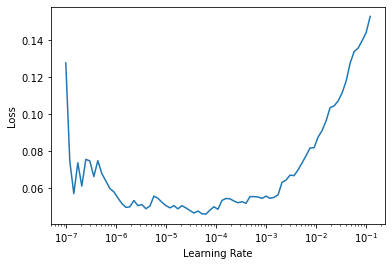

In [124]:
learn.unfreeze()
learn.lr_find()

In [125]:
learn.fit_flat_cos(3, slice(5e-5,5e-3), wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.067521,0.064040,0.971883,04:34
1,0.037071,0.074002,0.967997,04:34
2,0.016228,0.085814,0.969516,04:34


Epoch 1: reducing lr to 0.0005
Epoch 2: reducing lr to 3.694983898043167e-08


In [ ]:
#learn = learn.to_fp32()
#learn.save('eff3')